In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Load dataset
data_path = "../data/processed/ml_training_data_v2.csv"
df = pd.read_csv(data_path)

print(df.shape)
df.head()


(1169, 10)


,batting_diff,bowling_diff,overall_diff,recent_runs_diff,recent_wickets_diff,recent_econ_diff,toss_adv,home_adv,venue_win_rate_diff,team1_win
0,5.291662,8.260167,13.551830,2.854545,0.163636,-1.933563,-1,0,0.354167,1
1,-6.866101,-10.249467,-17.115568,-1.000000,0.254545,-1.131303,1,0,0.136364,1
2,-6.636761,-18.572381,-25.209142,4.472727,-0.095455,1.182283,-1,0,0.222222,0
3,2.537640,10.792871,13.330510,-6.100000,0.000000,1.046965,1,0,0.444444,1
4,-0.547613,-4.358547,-4.906160,0.745455,0.236364,1.455727,1,0,0.571429,1


In [2]:
X = df.drop("team1_win", axis=1)
y = df["team1_win"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (935, 9) Test: (234, 9)


In [3]:
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

pipe_lr.fit(X_train, y_train)

proba_lr = pipe_lr.predict_proba(X_test)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)

print("Logistic Accuracy:", accuracy_score(y_test, pred_lr))
print("Logistic AUC:", roc_auc_score(y_test, proba_lr))
print(classification_report(y_test, pred_lr, digits=4))


Logistic Accuracy: 0.6837606837606838
Logistic AUC: 0.7583284628872005
              precision    recall  f1-score   support

           0     0.7000    0.6525    0.6754       118
           1     0.6694    0.7155    0.6917       116

    accuracy                         0.6838       234
   macro avg     0.6847    0.6840    0.6836       234
weighted avg     0.6848    0.6838    0.6835       234



In [4]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=6,
    min_samples_leaf=10,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf.fit(X_train, y_train)

proba_rf = rf.predict_proba(X_test)[:, 1]
pred_rf = (proba_rf >= 0.5).astype(int)

print("RF Accuracy:", accuracy_score(y_test, pred_rf))
print("RF AUC:", roc_auc_score(y_test, proba_rf))
print(classification_report(y_test, pred_rf, digits=4))


RF Accuracy: 0.7008547008547008
RF AUC: 0.7567212156633547
              precision    recall  f1-score   support

           0     0.7264    0.6525    0.6875       118
           1     0.6797    0.7500    0.7131       116

    accuracy                         0.7009       234
   macro avg     0.7031    0.7013    0.7003       234
weighted avg     0.7033    0.7009    0.7002       234



In [5]:
results = pd.DataFrame({
    "Model": ["Logistic", "RandomForest"],
    "AUC": [
        roc_auc_score(y_test, proba_lr),
        roc_auc_score(y_test, proba_rf)
    ],
    "Accuracy": [
        accuracy_score(y_test, pred_lr),
        accuracy_score(y_test, pred_rf)
    ]
})

results


,Model,AUC,Accuracy
0,Logistic,0.758328,0.683761
1,RandomForest,0.756721,0.700855


In [7]:
pure_cols = [
    "batting_diff",
    "bowling_diff",
    "overall_diff",
    "recent_runs_diff",
    "recent_wickets_diff",
    "recent_econ_diff"
]

x1 = X_test[pure_cols].iloc[[i]]
x2 = -x1.copy()

pipe_lr_pure = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

pipe_lr_pure.fit(X_train[pure_cols], y_train)

p1 = pipe_lr_pure.predict_proba(x1)[0,1]
p2 = pipe_lr_pure.predict_proba(x2)[0,1]

print("Pure P1:", round(p1,3))
print("Pure P2:", round(p2,3))
print("Sum:", round(p1+p2,3))


Pure P1: 0.366
Pure P2: 0.651
Sum: 1.017


In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score


In [9]:
# Load final dataset
df = pd.read_csv("../data/processed/ml_training_data_v2.csv")

target = "team1_win"
X = df.drop(columns=[target])
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic pipeline
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

model.fit(X_train, y_train)

# Evaluation
proba = model.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, proba))
print("Accuracy:", accuracy_score(y_test, pred))


AUC: 0.7583284628872005
Accuracy: 0.6837606837606838


In [10]:
# Extract coefficients
coef = model.named_steps["lr"].coef_[0]
features = X.columns

importance_df = pd.DataFrame({
    "feature": features,
    "coefficient": coef,
    "abs_importance": np.abs(coef)
}).sort_values("abs_importance", ascending=False)

importance_df


,feature,coefficient,abs_importance
4,recent_wickets_diff,0.620682,0.620682
8,venue_win_rate_diff,0.502754,0.502754
3,recent_runs_diff,-0.360874,0.360874
5,recent_econ_diff,-0.314991,0.314991
7,home_adv,-0.309510,0.309510
0,batting_diff,0.268219,0.268219
2,overall_diff,0.061377,0.061377
1,bowling_diff,-0.046057,0.046057
6,toss_adv,0.009403,0.009403


In [12]:
sample = X_test.iloc[0]
sample_proba = model.predict_proba(sample.values.reshape(1,-1))[0,1]
print("Predicted P(team1 wins):", round(sample_proba,3))


Predicted P(team1 wins): 0.466


d:\ipl_win_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [13]:
# Get scaled values
scaled = model.named_steps["scaler"].transform(sample.values.reshape(1,-1))[0]
coefs = model.named_steps["lr"].coef_[0]

explain_df = pd.DataFrame({
    "feature": features,
    "value": sample.values,
    "scaled_value": scaled,
    "coefficient": coefs,
    "contribution": scaled * coefs
}).sort_values("contribution", ascending=False)

explain_df


d:\ipl_win_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,feature,value,scaled_value,coefficient,contribution
4,recent_wickets_diff,0.233333,1.413713,0.620682,0.877466
0,batting_diff,1.376478,0.319366,0.268219,0.085660
3,recent_runs_diff,-0.037500,-0.105957,-0.360874,0.038237
2,overall_diff,1.765086,0.148773,0.061377,0.009131
1,bowling_diff,0.388608,0.044923,-0.046057,-0.002069
6,toss_adv,-1.000000,-0.768203,0.009403,-0.007224
8,venue_win_rate_diff,0.181818,-0.033260,0.502754,-0.016722
5,recent_econ_diff,0.681565,0.532993,-0.314991,-0.167888
7,home_adv,1.000000,3.040858,-0.309510,-0.941176


In [14]:
sample_flip = -sample.copy()
p1 = model.predict_proba(sample.values.reshape(1,-1))[0,1]
p2 = model.predict_proba(sample_flip.values.reshape(1,-1))[0,1]

print("P(team1):", p1)
print("P(team2):", p2)
print("Sum:", p1 + p2)


P(team1): 0.466069934520149
P(team2): 0.40943726002680325
Sum: 0.8755071945469522


d:\ipl_win_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\ipl_win_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [15]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss


In [16]:
# Use the already trained logistic pipeline as base
base_model = model

calibrated_model = CalibratedClassifierCV(
    base_model,
    method="sigmoid",
    cv=5
)

calibrated_model.fit(X_train, y_train)


,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",Pipeline(step..._iter=2000))])
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'sigmoid'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit i

In [17]:
proba_uncal = base_model.predict_proba(X_test)[:,1]
proba_cal = calibrated_model.predict_proba(X_test)[:,1]

print("Brier (uncalibrated):", brier_score_loss(y_test, proba_uncal))
print("Brier (calibrated):", brier_score_loss(y_test, proba_cal))


Brier (uncalibrated): 0.19988812084114688
Brier (calibrated): 0.2002516499020379


In [18]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt


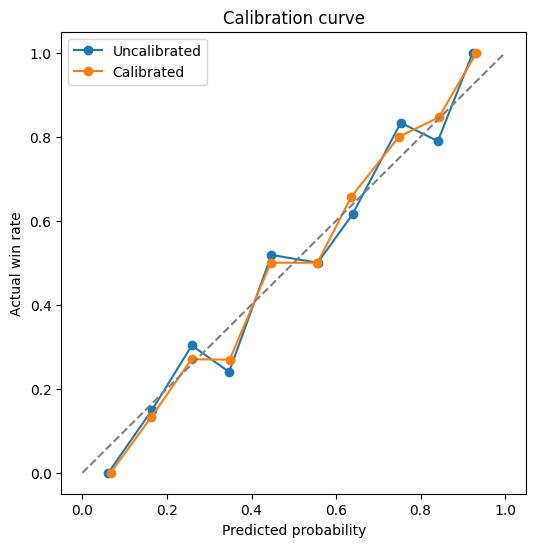

In [19]:
prob_true_u, prob_pred_u = calibration_curve(
    y_test, proba_uncal, n_bins=10
)

prob_true_c, prob_pred_c = calibration_curve(
    y_test, proba_cal, n_bins=10
)

plt.figure(figsize=(6,6))
plt.plot(prob_pred_u, prob_true_u, marker="o", label="Uncalibrated")
plt.plot(prob_pred_c, prob_true_c, marker="o", label="Calibrated")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("Predicted probability")
plt.ylabel("Actual win rate")
plt.title("Calibration curve")
plt.legend()
plt.show()


In [20]:
import joblib

joblib.dump(calibrated_model, "../models/calibrated_logistic_v2.joblib")
joblib.dump(X.columns.tolist(), "../models/feature_columns_v2.joblib")


['../models/feature_columns_v2.joblib']

In [21]:
def predict_match_proba(feature_row):
    X = pd.DataFrame([feature_row], columns=feature_cols)
    p1 = calibrated_model.predict_proba(X)[0,1]
    return {
        "team1_win_prob": round(p1,3),
        "team2_win_prob": round(1 - p1,3)
    }
